In [14]:
import numpy as np
import pandas as pd
import glob
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import keras
import cv2

In [15]:
cd sample_data/

[Errno 2] No such file or directory: 'sample_data/'
/content/sample_data


**Data Preprocessing**


In [16]:
df = pd.read_csv("XSS_dataset.csv")
df.head()

,Unnamed: 0,Sentence,Label
0,0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,2,"\t </span> <span class=""reference-text"">Steeri...",0
3,3,"\t </span> <span class=""reference-text""><cite ...",0
4,4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [17]:
df = df[df.columns[-2:]]
df.head()

,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [18]:
sentences = df['Sentence'].values

In [19]:
def convert_to_ASCII(sentence):
  sentence_ascii = []
  for i in sentence:
          if(ord(i)<8222):      # ”

            if(ord(i)==8217):   # ’
                sentence_ascii.append(132)

            if(ord(i)==8221):   # ”
                sentence_ascii.append(129)

            if(ord(i)==8220):   # “
                sentence_ascii.append(130)

            if(ord(i)==8216): # ‘
                sentence_ascii.append(131)

            if(ord(i)==8211): # –
                sentence_ascii.append(133)

            if (ord(i)<=128):           # if values less than 128, store or else discard
                    sentence_ascii.append(ord(i))

            else:
                    pass
  sentence_ascii_2d = np.zeros((10000))

  for i in range(len(sentence_ascii)):
    sentence_ascii_2d[i] = sentence_ascii[i]

  sentence_ascii_2d.shape=(100,100)

  return sentence_ascii_2d


In [20]:
sentence_ascii_3d =np.zeros((len(sentences),100,100))

for i in range(len(sentences)):

    temp = convert_to_ASCII(sentences[i])
    x = np.asarray(temp,dtype='float')
    temp =  cv2.resize(x, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
    temp/=133
    sentence_ascii_3d[i]=temp


In [22]:
input_data = sentence_ascii_3d.reshape(sentence_ascii_3d.shape[0], 100, 100, 1)
print(input_data.shape)

(13686, 100, 100, 1)


In [23]:
y=df['Label'].values
print(y)

[0 1 0 ... 1 0 0]


**Build CNN Model**

In [25]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(input_data,y, test_size=0.2, random_state=42)

In [26]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D,Flatten,Dropout,MaxPool2D, BatchNormalization

In [27]:
model=tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(64,(3,3), activation=tf.nn.relu, input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 256)       0

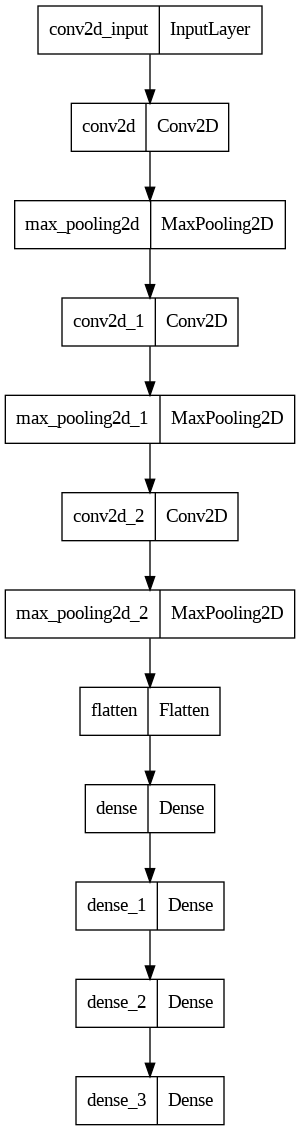

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [30]:
# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get('val_accuracy')>0.97):
#             print(" \n Reached 97% + validation accuracy")
#             self.model.stop_training=True
# callbacks = myCallback()

In [33]:
batch_size = 128
num_epoch = 10
model_log = model.fit(trainX, trainY,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=( testX,  testY),
          #callbacks=[callbacks]    reached 97% accuracy in Epoch 3
          )

Epoch 1/10
86/86 [==============================] - 7s 80ms/step - loss: 0.0597 - accuracy: 0.9821 - val_loss: 0.0567 - val_accuracy: 0.9825
Epoch 2/10
86/86 [==============================] - 7s 78ms/step - loss: 0.0518 - accuracy: 0.9852 - val_loss: 0.0605 - val_accuracy: 0.9843
Epoch 3/10
86/86 [==============================] - 7s 76ms/step - loss: 0.0531 - accuracy: 0.9848 - val_loss: 0.0854 - val_accuracy: 0.9668
Epoch 4/10
86/86 [==============================] - 7s 78ms/step - loss: 0.0442 - accuracy: 0.9868 - val_loss: 0.0518 - val_accuracy: 0.9832
Epoch 5/10
86/86 [==============================] - 7s 76ms/step - loss: 0.0377 - accuracy: 0.9893 - val_loss: 0.0470 - val_accuracy: 0.9843
Epoch 6/10
86/86 [==============================] - 7s 78ms/step - loss: 0.0333 - accuracy: 0.9897 - val_loss: 0.0416 - val_accuracy: 0.9858
Epoch 7/10
86/86 [==============================] - 7s 77ms/step - loss: 0.0318 - accuracy: 0.9903 - val_loss: 0.0422 - val_accuracy: 0.9894
Epoch 8/10
86

In [35]:
testX[0]

array([[[0.45112782],
        [0.84210526],
        [0.81203008],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [36]:
pred=model.predict(testX)
for i in range(len(pred)):
    if pred[i]>0.5:
        pred[i]=1
    elif pred[i]<=0.5:
        pred[i]=0

86/86 [==============================] - 1s 8ms/step


**Model Evaluation**

In [37]:
true=0
false=0

for i in range(len(pred)):
    if pred[i] == testY[i]:
        true+=1
    else:
        false+=1

print("correct predicted :: ", true)
print("false prediction :: ", false)

correct predicted ::  2712
false prediction ::  26


In [38]:
def accuracy_function(tp,tn,fp,fn):

    accuracy = (tp+tn) / (tp+tn+fp+fn)

    return accuracy

In [39]:
def precision_function(tp,fp):

    precision = tp / (tp+fp)

    return precision

In [40]:
def recall_function(tp,fn):

    recall=tp / (tp+fn)

    return recall

In [41]:
def confusion_matrix(truth,predicted):

    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for true,pred in zip(truth,predicted):
        if true == 1:
            if pred == true:
                true_positive += 1
            elif pred != true:
                false_negative += 1

        elif true == 0:
            if pred == true:
                true_negative += 1
            elif pred != true:
                false_positive += 1

    accuracy=accuracy_function(true_positive, true_negative, false_positive, false_negative)
    precision=precision_function(true_positive, false_positive)
    recall=recall_function(true_positive, false_negative)

    return (accuracy,
            precision,
           recall)

In [43]:
accuracy,precision,recall=confusion_matrix(testY,pred)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2}".format(accuracy, precision, recall))

 Accuracy : 0.9905040175310446 
 Precision : 0.9846461949265688 
 Recall : 0.9979702300405954
